In [19]:
import numpy as np
from scipy.stats import truncnorm


def sample_truncated_normal(
    min_val: float, max_val: float, std_dev: float, size: int = 1
):
    """
    Sample values from a truncated normal distribution.

    Args:
        min_val (float): The minimum value of the distribution.
        max_val (float): The maximum value of the distribution.
        mean (float): The mean of the normal distribution.
        std_dev (float): The standard deviation of the normal distribution.
        size (int): Number of samples to generate.

    Returns:
        np.ndarray: Array of sampled values.
    """
    # Compute the lower and upper bounds in standard normal units
    mean = max_val - min_val
    lower_bound = (min_val - mean) / std_dev
    upper_bound = (max_val - mean) / std_dev

    # Generate samples from the truncated normal distribution
    samples = truncnorm.rvs(
        lower_bound, upper_bound, loc=mean, scale=std_dev, size=size
    )
    return samples


In [7]:
min_val = 80
max_val = 120
mean = 100
std_dev = 2
num_samples = 1

# Generate samples
samples = sample_truncated_normal(min_val, max_val, mean, std_dev, size=num_samples)
print(samples)

[99.63798987]


[ 99.08110301  96.75709227  97.80744216 103.79156176 104.33768109
 102.85328345 101.61006579 101.74968581 100.87260234 100.80185852]


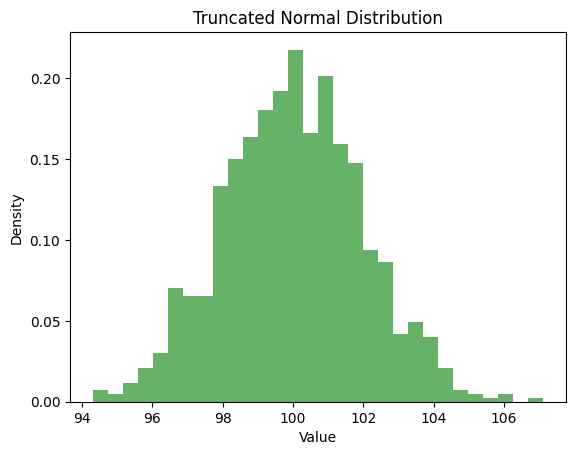

In [6]:
# Define parameters
min_val = 80
max_val = 120
mean = 100
std_dev = 2
num_samples = 1

# Generate samples
samples = sample_truncated_normal(min_val, max_val, mean, std_dev, size=num_samples)

# Check the output
print(samples[:10])  # First 10 samples

# Optional: Visualize the samples
import matplotlib.pyplot as plt
plt.hist(samples, bins=30, density=True, alpha=0.6, color='g')
plt.title("Truncated Normal Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()


In [105]:
import copy
import sys

sys.path.append(".")

from preprocessing.schemas import ImageLabelSchema, LabelCoordinatesSchema
from common.utils import read_json
from typing import List
import matplotlib.pyplot as plt
import cv2
from common.visualizations import get_image_with_targets

In [68]:
labels = read_json("/Users/vitalii/Desktop/Thesis/just_wash_your_hands/data/dataset/labels/labels_version_1.json")
labels = [ImageLabelSchema.from_dict(label) for label in labels]

In [69]:
def get_scaled_labels(image_labels: List[ImageLabelSchema], pixel_size: float):

    for image_label in image_labels:

        pixel_width = (
            image_label.labels[0].yolo_annotation.width
            * image_label.labels[0].image_shape.width
        )
        pixel_height = (
            image_label.labels[0].yolo_annotation.height
            * image_label.labels[0].image_shape.height
        )
        microns_width = sample_truncated_normal(
            image_label.labels[0].object.width.min_value,
            image_label.labels[0].object.width.max_value,
            4,
        )[0]
        microns_height = sample_truncated_normal(
            image_label.labels[0].object.height.min_value,
            image_label.labels[0].object.height.max_value,
            4,
        )[0]

        pixel_area = pixel_width * pixel_height
        microns_area = microns_width * microns_height

        actual_pixel_size = (microns_area / pixel_area) ** 0.5

        scaling_cf = pixel_size / actual_pixel_size

        image_label.scaling_cf = scaling_cf

    return image_labels

In [70]:
labels = get_scaled_labels(labels, 0.2506)

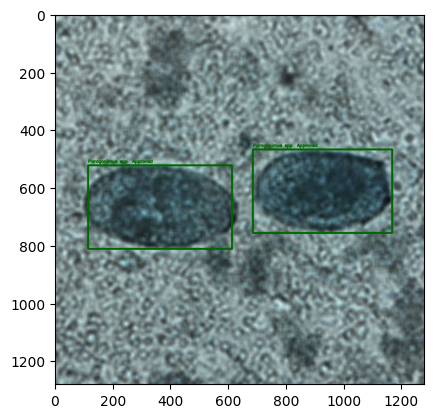

In [107]:
img_idx = 5786
orig_image_label = labels[img_idx]
orig_image_label.img_path = f"/Users/vitalii/Desktop/Thesis/just_wash_your_hands/data/dataset/images/{img_idx}.jpg"
image_label = copy.deepcopy(orig_image_label)
scaling_cf = image_label.scaling_cf

out_channels = 3
image = cv2.imread(image_label.img_path)
if image is None:
    print(f"Image at {image_label.img_path} could not be loaded.")

if out_channels == 1:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

if scaling_cf is not None:
    scaled_image = cv2.resize(
        image,
        dsize=(0, 0),
        fx=scaling_cf,
        fy=scaling_cf,
        interpolation=(cv2.INTER_LANCZOS4 if scaling_cf > 1 else cv2.INTER_AREA),
    )
    for label in image_label.labels:
        label.coordinates = label.coordinates*scaling_cf
else:
    scaled_image = image
    
scaled_height, scaled_width, scaled_channels = scaled_image.shape

out_height, out_width = 1280, 1280

top = (out_height - scaled_height) // 2 if scaled_height < out_height else 0
bottom = out_height - scaled_height - top if scaled_height < out_height else 0
left = (out_width - scaled_width) // 2 if scaled_width < out_width else 0
right = out_width - scaled_width - left if scaled_width < out_width else 0


padded_image = cv2.copyMakeBorder(scaled_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))

for label in image_label.labels:
    label.coordinates = LabelCoordinatesSchema(
        min_x=label.coordinates.min_x + left,
        max_x=label.coordinates.max_x + left,
        min_y=label.coordinates.min_y + top,
        max_y=label.coordinates.max_y + top,
    )

    label.update_yolo_and_area()

padded_width, padded_height, padded_channels = padded_image.shape

x_min = min([label.coordinates.min_x for label in image_label.labels])
y_min = min([label.coordinates.min_y for label in image_label.labels])
x_max = max([label.coordinates.max_x for label in image_label.labels])
y_max = max([label.coordinates.max_y for label in image_label.labels])

x_mid = (x_min + x_max) // 2
y_mid = (y_min + y_max) // 2

cv2.imwrite("1.jpg", padded_image)
image_label.img_path = f"1.jpg"

image_with_targets = get_image_with_targets(image_label)

plt.imshow(image_with_targets)

crop_x_start = x_mid - out_width // 2
crop_y_start = y_mid - out_height // 2
crop_x_end = crop_x_start + out_width
crop_y_end = crop_y_start + out_height

cropped_image = padded_image[crop_y_start:crop_y_end, crop_x_start:crop_x_end]

# Adjust bounding box coordinates based on the cropping and placement
for label in image_label.labels:
    label.coordinates = LabelCoordinatesSchema(
        min_x=label.coordinates.min_x - crop_x_start,
        max_x=label.coordinates.max_x - crop_x_start,
        min_y=label.coordinates.min_y - crop_y_start,
        max_y=label.coordinates.max_y - crop_y_start,
    )

    label.update_yolo_and_area()
    
cv2.imwrite("1.jpg", cropped_image)
image_label.img_path = f"1.jpg"
image_with_targets = get_image_with_targets(image_label)

plt.imshow(image_with_targets)

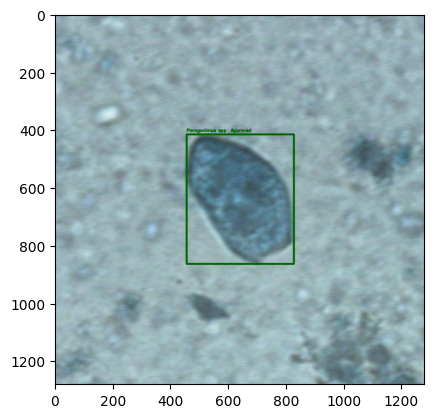

In [90]:
image_with_targets = get_image_with_targets(image_label)

plt.imshow(image_with_targets)

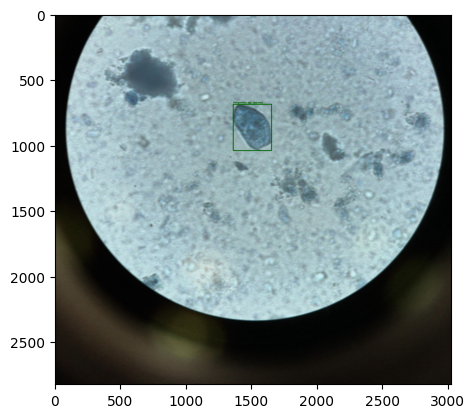

In [60]:
image_with_targets = get_image_with_targets(orig_image_label)

plt.imshow(image_with_targets)